In [57]:
import gc
# Clear all variables to free up memory
for name in dir():
    if not name.startswith('_') and name not in ['gc']:
        del globals()[name]

gc.collect()
print("All variables cleared and garbage collected")
import pandas as pd
import os
import sys

os.chdir('/shared/share_scp/coresignal/gitrepo_facebook')

if '/shared/share_scp/coresignal/gitrepo_facebook' in sys.modules:
    for module_name in list(sys.modules.keys()):
        if module_name.startswith('university_name_matcher'):
            del sys.modules[module_name]

from university_name_matcher import university_name_matcher
umatcher = university_name_matcher()

os.chdir('/shared/share_scp/coresignal')

All variables cleared and garbage collected


# Changelog after meeting 10/6

1. The 'founder_inc' variables are re-created with much higher values. The issue was that they were being matched as case-sensitive (i.e., 'inc' matched, but not 'Inc' or 'INC') and they had not included 'company' or 'co'


# 1. Convert the raw files into an analysis file
These are the files created from Python CSVs into Pandas

### 1.1 Read the files on education experience

In [2]:
universities_adopted_facebook = umatcher.load_university_data() 
x = universities_adopted_facebook[universities_adopted_facebook['instnm'].duplicated()].instnm

print("Number of duplicate university IDs:", universities_adopted_facebook[universities_adopted_facebook['instnm'].isin(x)].shape[0])


print("Number of NA in name", universities_adopted_facebook['instnm'].isna().sum())

Loaded 6528 universities from the dataset
Kept 6300 unique universities after removing duplicates
Number of duplicate university IDs: 0
Number of NA in name 0


In [3]:
import glob
education_files = sorted(glob.glob('processed_data2/coresignal_member_education_*linkedin*.pkl'))
print(f'Found {len(education_files)} education files')
coresignal_member_education_all = pd.concat(
    [pd.read_pickle(f) for f in education_files],
    ignore_index=True
)

coresignal_member_education_all['member_id'] = coresignal_member_education_all['member_id'].astype(int)
coresignal_member_education_all = coresignal_member_education_all.drop_duplicates()
member_ids = coresignal_member_education_all['member_id'].astype(int).unique()
print(f"Number of unique member IDs: {len(member_ids)}")

Found 122 education files
Number of unique member IDs: 10916706


In [4]:
#Scratch
print("Checking for duplicates in the combined DataFrame")
dups0= coresignal_member_education_all.duplicated(['id']).sum()
total0 = coresignal_member_education_all.shape[0]
coresignal_member_education_all = coresignal_member_education_all[~coresignal_member_education_all.title.str.contains("university of phoenix|devry university", case=False, na=False)]
dups1 = coresignal_member_education_all.duplicated(['id']).sum()
total1 = coresignal_member_education_all.shape[0]

pct0 = dups0 / total0 * 100
pct1 = dups1 / total1 * 100
print(f"Total duplicates found: {dups0:,} ({pct0:.2f}%). Dropped to {dups1:,} ({pct1:.2f}%) after filtering for 'university of phoenix|devry university'")


Checking for duplicates in the combined DataFrame
Total duplicates found: 3,345,980 (12.51%). Dropped to 571,993 (2.41%) after filtering for 'university of phoenix|devry university'


In [5]:

import numpy as np
from Levenshtein import distance as levenshtein_distance

# Function to safely calculate Levenshtein distance
def safe_levenshtein(str1, str2):
    if pd.isna(str1) or pd.isna(str2):
        return np.nan
    return levenshtein_distance(str(str1).lower(), str(str2).lower())

# Calculate Levenshtein distance using .loc to avoid SettingWithCopyWarning
coresignal_member_education_all.loc[:, 'levenshtein_distance'] = coresignal_member_education_all.apply(
    lambda row: safe_levenshtein(row['title'], row['instnm']), 
    axis=1
)

# Display the results
print("Levenshtein distances between title and university name:")


Levenshtein distances between title and university name:


In [6]:
coresignal_member_education_all.loc[:, 'is_duplicated'] = coresignal_member_education_all.duplicated(['id'])

pd.concat([coresignal_member_education_all[coresignal_member_education_all['is_duplicated']].sample(10),
              coresignal_member_education_all[~coresignal_member_education_all['is_duplicated']].sample(10)],
              ignore_index=True)[['id', 'member_id', 'title', 'instnm', 'levenshtein_distance', 'is_duplicated']]



,id,member_id,title,instnm,levenshtein_distance,is_duplicated
0,937702309,36862743,university of minnesota-twin cities,University of Minnesota-Morris,9.0,True
1,1070596117,448706998,northwood university-texas,Northwood University-Texas,0.0,True
2,1037270090,326032379,university of wisconsin-milwaukee,Gateway Technical College,26.0,True
3,920184483,427303201,lincoln tech,Lincoln College of Technology-West Palm Beach,33.0,True
4,1084930226,392785720,the art institutes,The Art Institute of Washington,13.0,True
5,845676365,269457554,universal technical institute of arizona inc,Universal Technical Institute-Auto Motorcycle ...,52.0,True
6,1008111716,435366872,lincoln tech,Lincoln Technical Institute-Union,21.0,True
7,995926581,56142308,art institute of atlanta,The Art Institute of Houston,11.0,True
8,1168745163,350571519,the art institutes,The Art Institute of Portland,12.0,True
9,1667195608,471939955,art institute of colorado,The Art Institute of Atlanta,11.0,True


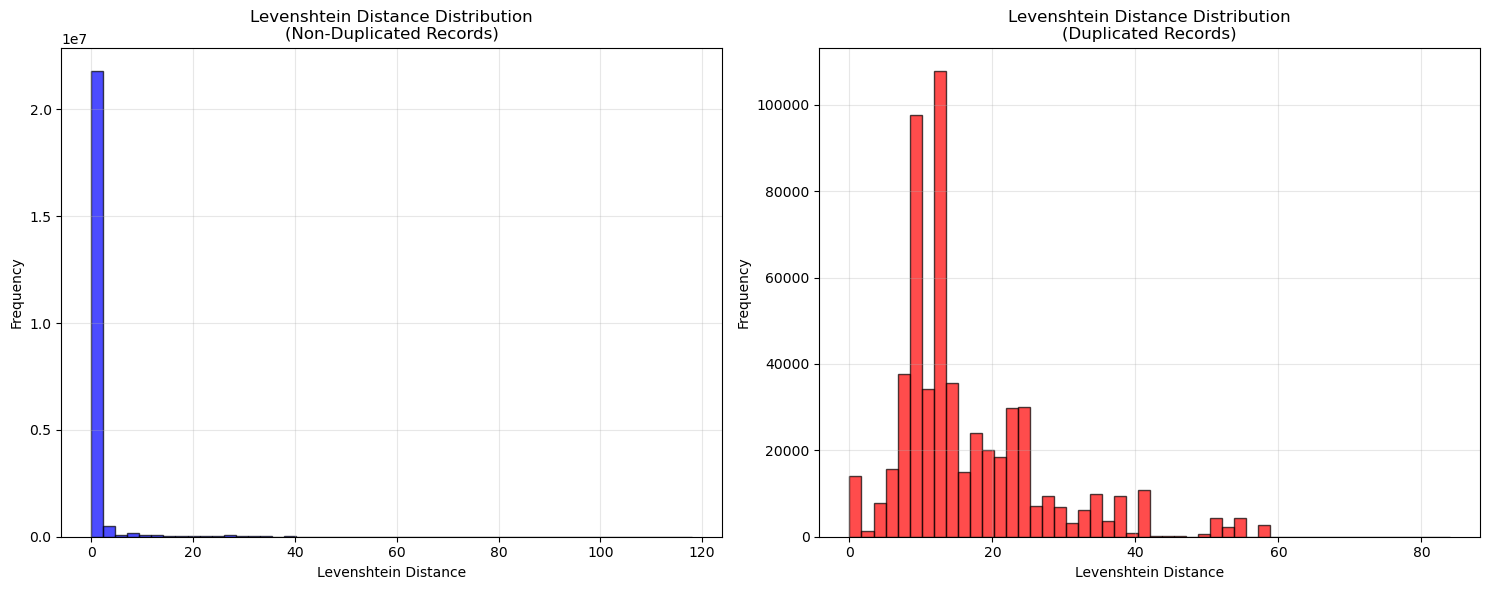

Non-duplicated records - Mean distance: 0.83, Median: 0.00
Duplicated records - Mean distance: 16.58, Median: 13.00
Non-duplicated count: 23,139,960
Duplicated count: 571,821


In [7]:
import matplotlib.pyplot as plt

# Create subplots for comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot histogram for non-duplicated records
non_duplicated_distances = coresignal_member_education_all[~coresignal_member_education_all['is_duplicated']]['levenshtein_distance'].dropna()
ax1.hist(non_duplicated_distances, bins=50, alpha=0.7, color='blue', edgecolor='black')
ax1.set_title('Levenshtein Distance Distribution\n(Non-Duplicated Records)')
ax1.set_xlabel('Levenshtein Distance')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)

# Plot histogram for duplicated records
duplicated_distances = coresignal_member_education_all[coresignal_member_education_all['is_duplicated']]['levenshtein_distance'].dropna()
ax2.hist(duplicated_distances, bins=50, alpha=0.7, color='red', edgecolor='black')
ax2.set_title('Levenshtein Distance Distribution\n(Duplicated Records)')
ax2.set_xlabel('Levenshtein Distance')
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Non-duplicated records - Mean distance: {non_duplicated_distances.mean():.2f}, Median: {non_duplicated_distances.median():.2f}")
print(f"Duplicated records - Mean distance: {duplicated_distances.mean():.2f}, Median: {duplicated_distances.median():.2f}")
print(f"Non-duplicated count: {len(non_duplicated_distances):,}")
print(f"Duplicated count: {len(duplicated_distances):,}")

In [8]:
coresignal_member_education_all = coresignal_member_education_all[~coresignal_member_education_all['is_duplicated']]

In [9]:
total_rows = coresignal_member_education_all.shape[0]
coresignal_member_education_all = coresignal_member_education_all[~coresignal_member_education_all['school_url'].str.endswith('linkedin.com/edu/school')]
print(f"Total rows before filtering: {total_rows:,}")
print(f"Total rows after filtering:  {coresignal_member_education_all.shape[0]:,}")

Total rows before filtering: 23,140,711
Total rows after filtering:  23,140,711


In [10]:
# Filter for bachelor's degrees or undergrad
coresignal_member_education = coresignal_member_education_all[
    coresignal_member_education_all['subtitle'].str.lower().str.contains(r'bachelor\'?s?|undergrad|\sb\.a\.|b\.s\.', na=False)
]
print(f"Filtered from {len(coresignal_member_education_all):,} to {len(coresignal_member_education):,} records for bachelor's or undergrad degrees.")


print(f"Deleting coresignal_member_education_all object")

del coresignal_member_education_all
gc.collect()

Filtered from 23,140,711 to 7,646,327 records for bachelor's or undergrad degrees.
Deleting coresignal_member_education_all object


77

### 1.2 Read the files on employment experience

In [ ]:
import glob
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing
import time

def read_pickle_file(filepath):
    return pd.read_pickle(filepath)

# Find all processed pickle files matching the pattern
os.chdir('/shared/share_scp/coresignal') #make sure it is in the right directory

processed_files = sorted(glob.glob('processed_data/coresignal_member_experience_*START*.pkl'))
print(f'Found {len(processed_files):,} files with experience.')

# Use parallel processing with manual progress tracking
max_workers = min(len(processed_files), multiprocessing.cpu_count())
print(f'Using {max_workers} workers for parallel processing.')

dataframes = []
start_time = time.time()

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Submit all tasks
    future_to_file = {executor.submit(read_pickle_file, file): file 
                     for file in processed_files}
    
    # Process completed tasks and show progress
    for i, future in enumerate(as_completed(future_to_file), 1):
        dataframes.append(future.result())
        
        # Print progress every 10 files or at the end
        if i % 10 == 0 or i == len(processed_files):
            elapsed = time.time() - start_time
            rate = i / elapsed if elapsed > 0 else 0
            remaining = len(processed_files) - i
            eta = remaining / rate if rate > 0 else 0
            
            print(f"Progress: {i:,}/{len(processed_files):,} files ({i/len(processed_files)*100:.1f}%) | "
                  f"Rate: {rate:.1f} files/sec | "
                  f"Time Left: {eta:.0f}s | "
                  f"Elapsed: {elapsed:.0f}s")

print("Concatenating dataframes...")
all_experience = pd.concat(dataframes, ignore_index=True)

print(f"Total rows in all experience data: {len(all_experience):,}")


In [ ]:
# limit to those with education records that will be our focus
all_experience = all_experience[all_experience['member_id'].isin(coresignal_member_education['member_id'])]
print(f"Total rows in all experience data after filtering to undergrad graduates: {len(all_experience):,}")

In [ ]:

import time

start_time = time.time()
print(f"Total rows in all experience data: {len(all_experience):,}")
print("Removing duplicates...")
key_columns = ['member_id','location','company_url','duration','order_in_profile','company_id', 'company_name', 'title', 'date_from', 'date_to']
all_experience = all_experience.drop_duplicates(subset=['id'])
print(f"Total rows in all experience data (after removing duplicates): {len(all_experience):,}")
elapsed_time = time.time() - start_time
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)
print(f"Time taken to remove duplicates: {minutes}m {seconds}s")

### 1.3 Testing and validations

In [ ]:
# Plot the number of entries by graduation year


# Create subplots for graduation year and start year
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot graduation year
grad_year_counts = coresignal_member_education.loc[(coresignal_member_education['year_to'] >= 1994) & (coresignal_member_education['year_to'] <= 2011),'year_to'].value_counts().sort_index()
ax1.bar(grad_year_counts.index, grad_year_counts.values, alpha=0.7, color='steelblue')
ax1.set_title('Number of Education Entries by Graduation Year (1994-2011)')
ax1.set_xlabel('Graduation Year')
ax1.set_ylabel('Number of Entries')
ax1.grid(True, alpha=0.3, axis='y')
ax1.tick_params(axis='x', rotation=45)

# Plot start year
start_year_counts = coresignal_member_education.loc[(coresignal_member_education['year_from'] >= 1994) & (coresignal_member_education['year_from'] <= 2011),'year_from'].value_counts().sort_index()
ax2.bar(start_year_counts.index, start_year_counts.values, alpha=0.7, color='orange')
ax2.set_title('Number of Education Entries by Start Year (1994-2011)')
ax2.set_xlabel('Start Year')
ax2.set_ylabel('Number of Entries')
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='x', rotation=45)


In [ ]:
# Get top 50 universities by number of graduates
top_50_universities = coresignal_member_education['instnm'].value_counts().head(50)

# Create the plot
plt.figure(figsize=(15, 10))
bars = plt.barh(range(len(top_50_universities)), top_50_universities.values, color='steelblue', alpha=0.7)

# Customize the plot
plt.yticks(range(len(top_50_universities)), top_50_universities.index, fontsize=8)
plt.xlabel('Number of Graduates')
plt.title('Top 50 Universities by Number of Graduates in Dataset')
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, top_50_universities.values)):
    plt.text(value + max(top_50_universities.values) * 0.01, i, f'{value:,}', 
             va='center', fontsize=7)

# Invert y-axis so highest counts are at top
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Filter data for University of Texas at Austin
ut_austin_data = coresignal_member_education[
    coresignal_member_education['instnm'] == 'The University of Texas at Austin'
]

# Get graduation year counts for UT Austin
ut_austin_grad_years = ut_austin_data['year_to'].value_counts().sort_index()

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(ut_austin_grad_years.index, ut_austin_grad_years.values, color='orange', alpha=0.7)
plt.title('Number of Graduates by Year - University of Texas at Austin')
plt.xlabel('Graduation Year')
plt.ylabel('Number of Graduates')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for year, count in ut_austin_grad_years.items():
    plt.text(year, count + max(ut_austin_grad_years.values) * 0.01, 
             f'{count:,}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print(f"Total UT Austin graduates in dataset: {len(ut_austin_data):,}")
print(f"Year range: {ut_austin_grad_years.index.min()} - {ut_austin_grad_years.index.max()}")


### 1.4 Output and save the analysis files

In [11]:
coresignal_member_education.to_pickle('coresignal_member_education_AnalysisFile_09302025.pkl')


In [ ]:

all_experience.to_pickle('all_experience_AnalysisFile_09302025.pkl')


# 2. Create the Stata analysis files from the complete datasets
Data loading from base files is done and now we add the things we are going to study

In [65]:
# Loads data from pickle files instead of re-creating it. 
# Uncomment as necessary

coresignal_member_education = pd.read_pickle('coresignal_member_education_AnalysisFile_09302025.pkl')
all_experience = pd.read_pickle('all_experience_AnalysisFile_09302025.pkl')


In [66]:
tot0 = all_experience.shape[0]
all_experience = all_experience[~all_experience.date_from.isnull()]
tot1 = all_experience.shape[0]
print(f"Dropped {tot0 - tot1:,} rows with null date_from ({((tot0 - tot1)/tot0*100):.2f}%)")

Dropped 337,948 rows with null date_from (0.51%)


In [ ]:
#all_experience = all_experience.sample(frac=.3)
# This cell takes about 5 minutes to run
print("variable: job_from",flush=True)
all_experience['job_from'] = all_experience['date_from'].str.extract(r'(\d{4})').astype(float)

print("variable: is_founder_only",flush=True)
all_experience['is_founder_only'] = all_experience['title'].str.contains('founder', case=False, na=False) 

print("variable: is_owner_only",flush=True)
all_experience['is_owner_only'] = all_experience['title'].str.contains(r'owner\b', case=False, na=False)

print("variable: is_founder_or_owner",flush=True)
all_experience['is_founder_or_owner'] = all_experience['is_founder_only'] | all_experience['is_owner_only']

print("variable: is_founder_or_owner_with_url, is_founder_or_owner_inc",flush=True)
all_experience['is_founder_or_owner_with_url'] = all_experience['is_founder_or_owner'] & all_experience['company_url'].notna()
all_experience['is_founder_or_owner_inc'] = all_experience['is_founder_or_owner'] & all_experience['company_name'].str.contains(r'\b(inc|corp|corporation|co|incorporated)\b', na=False, case=False)

print("variables: cofounder/coowner titles",flush=True)
all_experience['is_cofounder_or_coowner_title'] = all_experience['title_experience'].str.contains(r'co[-\s]?founder|co[-\s]?owner', case=False, na=False)
all_experience['is_cofounder_only_title'] = all_experience['title_experience'].str.contains(r'co[-\s]?founder', case=False, na=False)
all_experience['is_coowner_only_title'] = all_experience['title_experience'].str.contains(r'co[-\s]?owner', case=False, na=False)



In [ ]:
all_experience['job_from'] = all_experience['date_from'].str.extract(r'(\d{4})').astype(float)
all_experience.loc[all_experience['title'].str.contains('(product|assistant to|business process|program|process) owner', case=False, na=False) & all_experience['is_owner_only'], 'is_owner_only'] = False
all_experience.loc[(all_experience['title'] == "Owner Advisor") & all_experience['is_owner_only'], 'is_owner_only'] = False
all_experience.loc[(all_experience['title'].str.split().str.len() >= 4) & all_experience['is_owner_only'], 'is_owner_only'] = False


/tmp/8340490.1.debian.q/ipykernel_125356/1740427612.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  all_experience.loc[all_experience['title'].str.contains('(product|assistant to|business process|program|process) owner', case=False, na=False) & all_experience['is_owner_only'], 'is_owner_only'] = False


In [63]:
companies_of_owners = all_experience.groupby('title').sum('is_owner_only').sort('is_owner_only', ascending=False)

AttributeError: 'DataFrame' object has no attribute 'sort'

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    companies_of_owners.head(30)

### 2.1 Merge the education file and the universities file

In [16]:
print("Merging experience and education data...")
graduates_with_education_job_level = pd.merge(all_experience, coresignal_member_education, on='member_id',suffixes=('_experience', '_education'))

for i in range(11):
    print(f"Processing founder_in_year_{i}",flush=True)
    graduates_with_education_job_level[f'founder_in_year_{i}'] = (graduates_with_education_job_level['job_from'] == (graduates_with_education_job_level['year_to'] +i)) & graduates_with_education_job_level['is_founder_or_owner']
    graduates_with_education_job_level[f'founder_in_year_{i}'] = graduates_with_education_job_level[f'founder_in_year_{i}'].fillna(False).astype(int)

print("Calculating worked_as_engineer and worked_in_sales flags...")
graduates_with_education_job_level['worked_as_engineer'] = graduates_with_education_job_level['title_experience'].str.contains('engineer', case=False, na=False)
graduates_with_education_job_level['worked_in_sales'] = graduates_with_education_job_level['title_experience'].str.contains('sales', case=False, na=False)
graduates_with_education_job_level.shape

# 20_589_319 rows

Merging experience and education data...
Processing founder_in_year_0
Processing founder_in_year_1
Processing founder_in_year_2
Processing founder_in_year_3
Processing founder_in_year_4
Processing founder_in_year_5
Processing founder_in_year_6
Processing founder_in_year_7
Processing founder_in_year_8
Processing founder_in_year_9
Processing founder_in_year_10
Calculating worked_as_engineer and worked_in_sales flags...


(139797157, 47)

### 2.2 Add major to the graduate file

Create the graduate file, one line per graduate.

In [ ]:

cols =  ['is_founder_or_owner', 'is_owner_only', 'is_founder_only', 'is_cofounder_or_coowner', 'is_cofounder_only', 'is_coowner_only', 'worked_as_engineer', 'worked_in_sales', 'is_founder_or_owner_with_url', 'is_founder_or_owner_inc']
    
for col in cols:
    for i in [3,5,10]:
        all_experience[f'{col}_{i}_years'] = all_experience[col] & (all_experience['job_from'] <= (all_experience['year_to'] + i))

max_cols = {}
for col in cols:
    for i in [3, 5, 10]:
        col_name = f'{col}_{i}_years'
        max_cols[col_name] = 'max'


# Aggregate the data
graduates_person_level = graduates_with_education_job_level.groupby(['member_id', 'year_to', 'year_from', 'title_education', 'subtitle', 'unitid'], dropna=False).agg({    
    **max_cols
    }).reset_index()



In [47]:


# Rename columns for clarity
graduates_person_level.rename(columns={
    'year_from': 'year_start_college',
    'year_to': 'year_end_college',
    'member_id': 'linkedin_member_id',
    'title_education': 'university_title',
    'subtitle': 'university_major_raw'
}, inplace=True)

graduates_person_level.columns


graduates_person_level.sample(20)

,linkedin_member_id,year_end_college,year_start_college,university_title,university_major_raw,unitid,is_founder_or_owner_3_years,is_founder_or_owner_5_years,is_founder_or_owner_10_years,is_owner_only_3_years,...,worked_as_engineer_10_years,worked_in_sales_3_years,worked_in_sales_5_years,worked_in_sales_10_years,is_founder_or_owner_with_url_3_years,is_founder_or_owner_with_url_5_years,is_founder_or_owner_with_url_10_years,is_founder_or_owner_inc_3_years,is_founder_or_owner_inc_5_years,is_founder_or_owner_inc_10_years
294697,64711347,2007,2003,university of north texas,"Bachelor of Fine Arts (B.F.A.), Drawing & Pain...",227216,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1128356,194607899,2005,2001,university of notre dame,"Bachelor of Arts (B.A.), Political Science and...",152080,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
175315,42256945,2010,2008,troy university,Bachelors in Business Administration,102368,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2551452,396671477,2009,2005,emory university,Bachelor of Arts (BA),139658,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
328537,70515154,2006,2002,lambuth university,"Bachelor of Science, Health and Human Performance",220589,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1720733,279679397,2006,2005,indiana state university,"Bachelor of Science (B.S.), Human Resource Dev...",151324,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1097647,190018433,2010,2006,georgia state university,"Bachelors, Sociology",139940,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
427629,87331912,2002,1998,rowan university,"Bachelor's degree, Civil Engineering",184782,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2150438,357035403,2000,1996,calvin college,"Bachelor of Arts (B.A.), Major Psychology, Min...",169080,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2651617,414602948,2011,2007,utah valley university,"Bachelor's degree, Public Health Education and...",230737,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Keep only those graduates that obtained a bachelors based on the subtitle of the education row (this is a second cleaning)

In [48]:
# Remove rows where university_major_raw contains only generic degree terms without specific major
generic_patterns = [
    r'^bachelor\'?s?\s*degree$',
    r'^b\.?s\.?$',
    r'^b\.?a\.?$', 
    r'^bachelor\'?s?$',
    r'^degree$',
    r'^undergraduate$',
    r'^bachelor of science(\s*\(b\.?s\.?\))?$',
    r'^bachelor of arts(\s*\(b\.?a\.?\))?$',
    r'^bachelors$'
]

# Create a pattern that matches any of the generic patterns (case insensitive)
generic_pattern = '|'.join([f'({pattern})' for pattern in generic_patterns])

# Count rows before filtering
rows_before = len(graduates_person_level)

# Filter out rows with generic degree descriptions
graduates_person_level = graduates_person_level[
    ~graduates_person_level['university_major_raw'].str.lower().str.strip().str.match(generic_pattern, na=False)
]




rows_after = len(graduates_person_level)
print(f"Removed {rows_before - rows_after:,} rows with generic degree descriptions")
print(f"Remaining rows: {rows_after:,}")

Removed 90,892 rows with generic degree descriptions
Remaining rows: 3,004,235


In [49]:
# Clean university_major_raw by removing generic degree prefixes
import re

# Patterns to remove from the beginning of university_major_raw text
patterns_to_remove = [
    r'^bachelor of (applied\s+)?science(\s*\(b\.?s\.?\))?\s*,?\s*',
    r'^bachelor of arts(\s*\(b\.?a\.?\))?\s*,?\s*',
    r'^bachelor\'?s? degree\w?,']

# Combine all patterns
combined_pattern = '|'.join(patterns_to_remove)


# Apply cleaning (case insensitive)
graduates_person_level['university_major_clean'] = graduates_person_level['university_major_raw'].str.replace(
    combined_pattern, '', case=False, regex=True
).str.strip()

graduates_person_level['university_major_clean'] = (
    graduates_person_level['university_major_clean']
    .str.replace(r'\b[Mm]inor\b[ \w]*', '', regex=True)
    .str.strip()
)



# Remove entries that are just short parenthetical notes (e.g., "(BA)", "(BS)")
graduates_person_level = graduates_person_level[~graduates_person_level['university_major_clean'].str.contains(r'^\(.{0:6}\)$')]
print(f"\nAfter cleaning - sample of university_major_raw:")



After cleaning - sample of university_major_raw:


#### 2.2.2 Define the major categorization  keywords

In [50]:
x =  ['asian', 'hispanic', 'african','latin american','gender','feminist','asian american', 'african american','frech','russian','middle eastern','european','caribbean','women\'s','chicano','jewish']
studies_groups_social_science  = [g + ' studies' for g in x]

majors_categories = {
    "Engineering or Computer": {"keywords": ['engineering', 'computer', 'software', 'electronic', 'information systems', 'information technology', 'informatics', 'robotics', 'machine learning', 'artificial intelligence', 'cybersecurity',
                            'architecture', 'urban planning'],
                               "variable_name":"engineering_or_computer"},
    "Natural Science": {"keywords": ['biology', 'biological', 'chemistry', 'physics', 'environmental', 'geology', 'earth', 'astronomy', 'astrophysics', 'meteorology', 'biotechnology', 'biochemistry', 'biotech', 'biochem', 'neuroscience', 'marine', 'oceanography', 'ecology', 'genetics'],
                       "variable_name":"natural_science"},
    "Math": {"keywords": ['math', 'mathematics', 'statistics', 'statistical', 'stats', 'data science', 'analytics'],
             "variable_name":"math"},
    "Education": {"keywords": ['education', 'teacher', 'teaching', 'instructional', 'curriculum', 'pedagogy', 'educational','speech therapy'],
                  "variable_name":"education"},
    "Clinical Work": {"keywords": ['social work', 'pre-med', 'pharmacy', 'nursing', 'health', 'mental', 'therapy', 'clinical', 'counseling'],
                      "variable_name":"clinical_work"},
    "Law / Climinology": {"keywords": ['law', 'legal', 'criminology', 'criminal', 'justice', 'landscape'],
                          "variable_name":"law_climinology"},
    "Economics and Finance": {"keywords": ['economics', 'econ', 'finance', 'financial', 'banking', 'investment', 'econometrics'],
                              "variable_name":"economics_and_finance"},
    "Business (not Economics / Finance)": {"keywords": ['public relations','business', 'management', 'accounting', 'marketing', 'public relations', 'administration', 'advertising', 'human resources', 'operations', 'supply chain', 'organizational behavior'],
                                           "variable_name":"business_not_economics_finance"},
    "Social Science (not Economics)": {"keywords": (['social science', 'history', 'sociology', 'anthropology', 'international relations', 'political science', 'government',
                                                   'policy',  'ethnic', 'cultural', 'religion', 'philosophy','liberal art'] + 
                                studies_groups_social_science)
                                ,"variable_name":"social_science_not_economics"}
                               ,
    "Arts": {"keywords": ['fine art', 'design', 'graphic', 'music', 'theater', 'film', 'cinema', 'photography', 'fashion', 'visual', 'dance', 'performing'],
              "variable_name":"arts"},
    "Communications": {"keywords": ['communication', 'communications', 'media', 'journalism', 'broadcasting'],
                      "variable_name":"communications"},
    "English": {"keywords": ['english', 'literature', 'writing'],
                "variable_name":"english"},
    "Psychology": {"keywords": ['psychology'],
                   "variable_name":"psychology"}
}





In [51]:
subtitle =graduates_person_level['university_major_clean'].dropna().astype(str).sample(100, random_state=42).tolist()[1]

print(f"subtitle: {subtitle}")
subtitle_lower = subtitle.lower()
for major, keywords in majors_categories.items():
    for keyword in keywords:
        if keyword in subtitle_lower:
            print(f"major: {major}")


subtitle: Bachelor of Business Administration, Finance


#### 2.2.3 Run algorithm to categorize majors based on keywords, takes 10 mins or so

In [52]:
from tqdm import tqdm
tqdm.pandas()

# Assign major group to each observation in coresignal_member_education
def assign_major(subtitle, majors_categories):
    if pd.isna(subtitle):
        return None

    subtitle_lower = subtitle.lower()
    for major in majors_categories.keys():
        keywords = majors_categories[major]["keywords"]
        for keyword in keywords:
            if keyword in subtitle_lower:
                return (major, "major_" + majors_categories[major]["variable_name"])
    return ('Other', 'major_other')

print("Applying major assignment to the dataset...")

# Apply the assign_major function and extract results
major_results = graduates_person_level['university_major_clean'].progress_apply(
    lambda x: assign_major(x, majors_categories)
)

# Extract the major categories and variable names
major_categories = [result[0] if result else 'Other' for result in major_results]
major_variables = [result[1] if result else 'major_other' for result in major_results]

# Create university_major_categorized by joining multiple categories with semicolons
graduates_person_level['university_major_categorized'] = [
    '; '.join(sorted(set(cat.split('; ')))) if cat else 'Other' 
    for cat in major_categories
]

# Create dummy variables for each major category
for major_category, details in majors_categories.items():
    var_name = f"major_{details['variable_name']}"
    graduates_person_level[var_name] = [
        1 if var_name in str(major_var) else 0 
        for major_var in major_variables
    ]

# Add major_other dummy variable
graduates_person_level['major_other'] = [
    1 if major_var == 'major_other' else 0 
    for major_var in major_variables
]



Applying major assignment to the dataset...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3004235/3004235 [00:21<00:00, 137043.31it/s]


### 2.4 Data testing and visualizations

In [ ]:
print(f'Total number of graduates: {graduates_person_level.shape[0]:,}')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate means by university major category
major_founder_stats = graduates_person_level.groupby('university_major_categorized').agg({
    'is_founder_only': 'mean',
    'is_owner_only': 'mean',
    'founder_company_has_url': 'mean',
    'owner_company_has_url': 'mean',
    'founder_company_name_words': 'mean',
    'owner_company_name_words': 'mean'
}).reset_index()
major_founder_stats['share_founders'] = major_founder_stats['is_founder_only']/(major_founder_stats['is_founder_only'] + major_founder_stats['is_owner_only'])

# Sort categories
major_founder_stats = major_founder_stats.sort_values('share_founders', ascending=False)

# Create positions
y = np.arange(len(major_founder_stats))
bar_height = 0.35  

# Define clearer colors
colors = {
    "is_founder_only": "#1f77b4",       # blue
    "is_owner_only": "#2ca02c",         # green
    "founder_company_has_url": "#9467bd",   # purple
    "owner_company_has_url": "#ff7f0e",     # orange
    "founder_company_name_words": "#d62728",# red
    "owner_company_name_words": "#8c564b"   # brown
}

fig, axes = plt.subplots(2, 1, figsize=(15, 18), sharey=True)

# --- Plot 1: Founder/Owner rates ---
axes[0].barh(y - bar_height/2, major_founder_stats['is_founder_only'],
             height=bar_height, color=colors["is_founder_only"], alpha=0.85, label='Founder Only')
axes[0].barh(y + bar_height/2+.1, major_founder_stats['is_owner_only'],
             height=bar_height, color=colors["is_owner_only"], alpha=0.85, label='Owner Only')
axes[0].set_title("Entrepreneurship Rates by Major Category")
axes[0].set_xlabel("Mean Rate Within 10 Years")
axes[0].set_yticks(y)
axes[0].set_yticklabels(major_founder_stats['university_major_categorized'], fontsize=9)
axes[0].grid(axis='x', alpha=0.3)
axes[0].legend()
axes[0].invert_yaxis()

# --- Plot 2: Company has URL (founder vs owner) ---
axes[1].barh(y - bar_height/2, major_founder_stats['founder_company_has_url'],
             height=bar_height, color=colors["founder_company_has_url"], alpha=0.85, label='Founder Co. Has URL')
axes[1].barh(y + bar_height/2+.1, major_founder_stats['owner_company_has_url'],
             height=bar_height, color=colors["owner_company_has_url"], alpha=0.85, label='Owner Co. Has URL')
axes[1].set_title("Share of Companies with a URL by Major Category")
axes[1].set_xlabel("Mean Share")
axes[1].grid(axis='x', alpha=0.3)
axes[1].legend()


plt.tight_layout()
plt.show()


### 2.4 Save pickle file

In [53]:
graduates_person_level.to_pickle('graduates_person_level_AnalysisFile_093025.pkl')

### 2.5 Report summary statistics of file

In [54]:
# Print summary statistics for all major categories
print("Summary Statistics for Major Categories:")
print("=" * 50)

# Calculate percentages for each major category
total_graduates = len(graduates_person_level)
print(f"Total graduates: {total_graduates:,}")
print()

# Print statistics for each major category dummy variable
major_dummy_cols = [col for col in graduates_person_level.columns if col.startswith('major_')]
for col in major_dummy_cols:
    count = graduates_person_level[col].sum()
    percentage = (count / total_graduates) * 100
    print(f"{col:<35}: {count:>8,} ({percentage:>5.1f}%)")

print()
print("University Major Categorized Distribution:")
print("-" * 45)
major_dist = graduates_person_level['university_major_categorized'].value_counts()
for category, count in major_dist.items():
    percentage = (count / total_graduates) * 100
    print(f"{category:<35}: {count:>8,} ({percentage:>5.1f}%)")


Summary Statistics for Major Categories:
Total graduates: 3,004,235

major_engineering_or_computer      :  341,492 ( 11.4%)
major_natural_science              :  243,127 (  8.1%)
major_math                         :   37,656 (  1.3%)
major_education                    :  142,493 (  4.7%)
major_clinical_work                :  134,298 (  4.5%)
major_law_climinology              :   83,627 (  2.8%)
major_economics_and_finance        :  180,592 (  6.0%)
major_business_not_economics_finance:  672,701 ( 22.4%)
major_social_science_not_economics :  298,981 ( 10.0%)
major_arts                         :  172,703 (  5.7%)
major_communications               :  166,455 (  5.5%)
major_english                      :   93,017 (  3.1%)
major_psychology                   :  148,997 (  5.0%)
major_other                        :  288,096 (  9.6%)

University Major Categorized Distribution:
---------------------------------------------
Business (not Economics / Finance) :  672,701 ( 22.4%)
Engineering or 

In [34]:
graduates_person_level['major_business_not_economics_finance']


0          1
1          0
2          0
3          1
4          1
          ..
3095122    1
3095123    0
3095124    1
3095125    0
3095126    0
Name: major_business_not_economics_finance, Length: 3004235, dtype: int64

In [55]:

x = graduates_person_level[graduates_person_level['major_business_not_economics_finance'] == 1].sample(200)

with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    display(x[['university_major_clean','university_major_raw']])

,university_major_clean,university_major_raw
1600185,"Business Administration, Human Resources","Bachelor of Science, Business Administration, Human Resources"
2396547,Hospitality and Tourism Management,"Bachelor of Science (BS), Hospitality and Tourism Management"
536642,"Bachelor of Business Administration (BBA), Marketing","Bachelor of Business Administration (BBA), Marketing"
1846099,"- BS, Business Administration and Management, General","Bachelor of Science - BS, Business Administration and Management, General"
1262181,"Bachelor of Business Administration (BBA), Business Administration and Management, General","Bachelor of Business Administration (BBA), Business Administration and Management, General"
1826287,"Business Administration and Management, General","Bachelor's degree, Business Administration and Management, General"
2081550,Marketing,"Bachelor of Arts, Marketing"
1954993,Business Management,"Bachelor's Degree, Business Management"
3093586,Accounting,"Bachelor's degree, Accounting"
2857175,Accounting,"Bachelor of Science (B.S.), Accounting"


In [ ]:
# Create a sample dataset showing 20 rows for each major category where the dummy variable is True
sample_data = []

# Get all major dummy variables
major_dummy_vars = [col for col in graduates_person_level.columns if col.startswith('major_')]

for major_var in major_dummy_vars:
    # Get 20 rows where this major dummy is True
    major_true_rows = graduates_person_level[graduates_person_level[major_var] == 1].sample(min(20, graduates_person_level[major_var].sum()), random_state=42)
    
    # Add the matched variable name to each row
    for _, row in major_true_rows.iterrows():
        sample_data.append({
            'matched_major_variable': major_var,
            'university_major_raw': row['university_major_raw'],
            'university_major_clean': row['university_major_clean']
        })

# Create the dataset
major_samples_df = pd.DataFrame(sample_data)
print(f"Created dataset with {len(major_samples_df)} rows showing major category matches")
print(f"Number of unique major variables: {major_samples_df['matched_major_variable'].nunique()}")

# Display first few rows
# Create a sample dataset showing 20 rows for each major category where the dummy variable is True
sample_data = []

# Get all major dummy variables
major_dummy_vars = [col for col in graduates_person_level.columns if col.startswith('major_')]

for major_var in major_dummy_vars:
    # Get 20 rows where this major dummy is True
    major_true_rows = graduates_person_level[graduates_person_level[major_var] == 1].sample(min(20, graduates_person_level[major_var].sum()), random_state=42)
    
    # Add the matched variable name to each row
    for _, row in major_true_rows.iterrows():
        sample_data.append({
            'matched_major_variable': major_var,
            'university_major_raw': row['university_major_raw']
        })

# Create the dataset
major_samples_df = pd.DataFrame(sample_data)
print(f"Created dataset with {len(major_samples_df)} rows showing major category matches")
print(f"Number of unique major variables: {major_samples_df['matched_major_variable'].nunique()}")


# Display the complete dataset with all rows
print("Displaying all rows in major_samples_df:")
with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
    display(major_samples_df)

In [ ]:

#
print("Sampling 10 rows showing subtitle and major-related columns:")
major_cols = [col for col in graduates_person_level.columns if 'major' in col.lower()]
#graduates_person_level.sample(10)[major_cols]
with pd.option_context('display.max_colwidth', None):
    display(graduates_person_level[graduates_person_level.university_major_categorized.str.contains("Social Sc")].sample(50)[['university_major_raw','university_major_categorized'] ])

In [ ]:
graduates_person_level.sample(5000)[['university_major_raw','university_major_clean','university_major_categorized']].to_csv('graduates_person_level_majors_sample5000.csv', index=False)

# 3 Store files for Stata analysis

In [56]:
# -----------------------------------------------------------
# Each row is one person
# University that they went to --> well matched into a single ID using Runjing's data.

# Start and end year and month of bachelor's degree
     # would be cool to show collaboration across groups. 

# Do they start a firm within 3, 5, or 10 years

# -----------------------------------------------------------
# Separate dataset of founding events: person id, firm id, founding date, location of firm. 

print("Storing graduates_person_level", flush=True)
#graduates_person_level = graduates_person_level[~graduates_person_level.linkedin_member_id.duplicated() ]
graduates_person_level.to_stata("graduates_person_level_10312025.dta",  version=118)




Storing graduates_person_level


/tmp/8340490.1.debian.q/ipykernel_125356/605461497.py:15: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    is_founder_or_owner_with_url_3_years   ->   is_founder_or_owner_with_url_3_y
    is_founder_or_owner_with_url_5_years   ->   is_founder_or_owner_with_url_5_y
    is_founder_or_owner_with_url_10_years   ->   is_founder_or_owner_with_url_10_
    major_business_not_economics_finance   ->   major_business_not_economics_fin
    major_social_science_not_economics   ->   major_social_science_not_economi

If this is not what you expect, please make sure you have Stata-compliant
column names in your DataFrame (strings only, max 32 characters, only
alphanumerics and underscores, no Stata reserved words)

  graduates_person_level.to_stata("graduates_person_level_10312025.dta",  version=118)


In [ ]:

#Scratch
#graduates_person_level = pd.read_stata("graduates_person_level_091182025.dta")


with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(graduates_person_level.year_start_college.value_counts().sort_index())

# Add: subtitle to a cleaned major
# Founded within years: finer from 1 to 10 years, every year -- make count per year, not cumulative.

In [ ]:
founder_events.company_url.sample(20)
# Tag the LLCs, Partnership, or Corporation
# re-title variables to make it more clear.


# third file
# Need the company industry --- is there a company id to match from?

## Early employee? 

In [ ]:

print("Storing founder_events", flush=True)
founder_events = graduates_with_education_job_level[graduates_with_education_job_level['is_founder']].copy()
# Convert id column to string to avoid Stata export error
#founder_events['id'] = founder_events['id'].astype(str)
#founder_events.to_stata("founder_events.dta",   version=118)


# Convert all columns to string to avoid Stata export issues
for col in founder_events.columns:
    founder_events[col] = founder_events[col].astype(str)

founder_events.dtypes

founder_events.to_stata("founder_events.dta",  version=118)

In [ ]:
founder_events

## Testing internally of the graduate file


In [ ]:
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np

import matplotlib.pyplot as plt

# Load the graduates_person_level data if not already loaded
#graduates_person_level = pd.read_pickle('graduates_person_level_AnalysisFile.pkl')

# Prepare the data for regression
# Create dummy variables for college-year fixed effects
graduates_person_level['college_year'] = graduates_person_level['unitid'].astype(str) + '_' + graduates_person_level['year_end_college'].astype(str)

# Get dummies for college-year fixed effects
college_year_dummies = pd.get_dummies(graduates_person_level['college_year'], prefix='college_year')

# Prepare X variables (graduation year + college-year fixed effects)
X = pd.concat([
    graduates_person_level[['year_end_college']],
    college_year_dummies
], axis=1)

# Use founded_within_10_years as dependent variable
y = graduates_person_level['founded_within_10_years']

# Create interaction terms for major categories with graduation year
major_dummy_vars = [col for col in graduates_person_level.columns if col.startswith('major_')]

# Create interaction terms (graduation year * major dummy)
for major_var in major_dummy_vars:
    graduates_person_level[f'{major_var}_x_year'] = graduates_person_level[major_var] * graduates_person_level['year_end_college']

# Add interaction terms to X variables
interaction_cols = [col for col in graduates_person_level.columns if col.endswith('_x_year')]
X = pd.concat([
    graduates_person_level[['year_end_college']],
    graduates_person_level[major_dummy_vars],
    graduates_person_level[interaction_cols],
    college_year_dummies
], axis=1)

# Remove rows with missing values
mask = ~(X.isna().any(axis=1) | y.isna())
X_clean = X[mask]
y_clean = y[mask]

print(f"Running regression with {len(X_clean):,} observations")
print(f"Number of features: {X_clean.shape[1]}")

# Fit the regression
reg = LinearRegression()
reg.fit(X_clean, y_clean)

# Get coefficient for year_end_college
year_coef = reg.coef_[0]
print(f"Coefficient for year_end_college: {year_coef:.6f}")

# Plot the coefficient
plt.figure(figsize=(10, 6))
plt.bar(['Year of Graduation'], [year_coef], color='steelblue', alpha=0.7)
plt.title('Effect of Graduation Year on Founding a Company Within 10 Years')
plt.ylabel('Coefficient')
plt.xlabel('Variable')
plt.grid(axis='y', alpha=0.3)

# Add value label on bar
plt.text(0, year_coef + (abs(year_coef) * 0.1), f'{year_coef:.6f}', 
         ha='center', va='bottom' if year_coef > 0 else 'top')

plt.tight_layout()
plt.show()

# Print regression summary
print(f"\nRegression Results:")
print(f"R-squared: {reg.score(X_clean, y_clean):.6f}")
print(f"Number of observations: {len(X_clean):,}")
print(f"Mean of dependent variable: {y_clean.mean():.6f}")

In [ ]:
graduates_person_level.columns

In [ ]:
import pandas as pd
from linearmodels.iv import AbsorbingLS

graduates_person_level['college_year'] = graduates_person_level['unitid'].astype(str) + '_' + graduates_person_level['year_end_college'].astype(str)

# Make FEs categorical to save memory
df = graduates_person_level.assign(
    fe1=lambda d: d.unitid.astype('category'),    
    fe_x=lambda d: d.year_end_college.astype('int16')    
).dropna(subset=['founded_within_10_years','year_end_college','fe1','fe_x'])

# Prepare dependent and independent variables
dependent = df['founded_within_10_years']
exog = pd.get_dummies(graduates_person_level['year_end_college'], prefix='xx')
absorb = df[['unitid']]   # Fixed effects variable



# Create and fit the model
mod = AbsorbingLS(dependent, exog, absorb=absorb)
res = mod.fit(
    cov_type='clustered',
    clusters=df[['fe1']]     # one- or multi-way clustering
)
print(res.summary)


In [ ]:

universities_adopted_facebook.fb_date.value_counts()
#graduates_person_level.columns
#universities_adopted_facebook.columns

# Setup the industry file

In [ ]:

# Read the company data CSV file efficiently
print("Reading coresignal_company.csv file...")
print("Note: This is a large file (11GB), loading may take several minutes...")

coresignal_company = pd.read_csv('coresignal_company.csv')
print(f"Company data loaded: {len(coresignal_company):,} rows, {len(coresignal_company.columns)} columns")
print("Columns in company data:", coresignal_company.columns.tolist())

In [ ]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import re

# First, let's examine the data we're working with
print("Founder events shape:", founder_events.shape)
print("Company data shape:", coresignal_company.shape)

# Check the company_url column in founder_events
print("\nCompany URL info in founder_events:")
print(f"Total founder events: {len(founder_events):,}")
print(f"Non-null company URLs: {founder_events['company_url'].notna().sum():,}")
print(f"Missing company URLs: {founder_events['company_url'].isna().sum():,}")

# Check if there's a URL column in coresignal_company
print("\nColumns in coresignal_company that might contain URLs:")
url_columns = [col for col in coresignal_company.columns if 'url' in col.lower() or 'link' in col.lower()]
print(url_columns)

# Also check for company name columns
name_columns = [col for col in coresignal_company.columns if 'name' in col.lower() or 'company' in col.lower()]
print("\nColumns in coresignal_company that might contain company names:")
print(name_columns)

# to dos and different changes after 10/06


GET THE DATA TO RUNJING 

- Create a better definition of co-founder if we can (being part of two companies by URL)
    - Then add co-founding across different colleges. 
    - 
- Move the  franchisees into their own definition.

